<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Комментарий ревьюера</b>


Привет, Максим! Давай знакомиться! Меня зовут Дмитрий Махортов, и я буду проверять твой проект. Сразу предлагаю общение на «ты» 🙂, но если тебе это не комфортно, то дай знать, и мы перейдем на «вы». 

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе погрузиться в увлекательный мир работы с данными и вырасти в крепкого профи. Это отдаленная цель. А ближайшая - сделать твою работу еще лучше )).
   
    
        
Расскажу как обычно проходит проверка:    
Бывают моменты, которые требуют пристального внимания. Комментарии по ним выделены <span style='background-color:#F7B3A4'> красным цветом </span> и обозначены значком 🛑. После их доработки проект будет принят.  🙂
 
<span style='background-color:#B7EBA7'> Зеленым цветом </span> и значком ✅ отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах. Или советы «со звездочкой», которые помогут тебе в будущем.

<span style='background-color:#F9EDA6'>Жёлтым цветом </span> и значком ⚠️ выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом**. Выбери для своих комментариев какой-то заметный цвет, так мне будет легче отследить изменения. Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Можешь использовать этот комментарий. Просто удали этот текст и вместо него напиши свой 🙂

</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
    
    
Как я вижу ты не закончил проект, поэтому извини, ревью не будет.
    
Также на будущее прошу тебя за помощью (что-то не работает) обращатья к преподавателю, но не ревьюеру. Для ревьюера поиск ошибок и отладка кода это неоплачиваемая  нагрузка.
    
Сразу скажу, что ошибка у тебя была хитрая и на её поиск я потратил полтора часа.  Попробую дать немного советов по подобного рода отладкам.
    
Для начала нужно проверить что модель вообще учится. Здесь советую поступить просто: берем модель "бейзлайн", и пытаемся её жестко переобучить (мониторя метрику на обучающей выборке). Учится - хорошо, нет - где-то ошибка либо в данных, либо в модели, либо в коде обучения.
    
Оказалось что модель не учится... Метрика rmse не хочет снижаться ниже 9_000. Просто никак.
    
Я полностью перепроверил подготовку признаков, жестких ошибок не нашел. 
    
А когда начал проверять таргет, то нашел. Дело в том, что таргет должен подаваться в виде вектора-столбца, и иметь размерность например `torch.Size([184, 1])`. А у тебя была просто строка.  Как следствие лосс расчитывался неверно и модель просто не могла обучиться.
    
Я просто добавил `.reshape(-1, 1)` превратив строку в столбец и всё заработало (пошло обучение на обучающей выборке).    
    
------------------------------------
    
Позволь также оставить тебе несколько советов:
    
    
    
 - мониторь метрику как на обучающей выборке, так и на тестовой (валидационной). Это позволяет понимать, как можно улучшить модель
 - учи модели "до упора", т.е. пока метрика на тестовой (валидационной) выборке улучшается
   
    
Этим советам будут посвящены два следующих комментария.
    
    
    



</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
На мой взгляд ты воспринимаешь "количество эпох" как гиперпараметр "спущеный с верху". Т.е. устанавливаем параметры сети, запускаем обучение и смотрим на результат.
    
Но в случае с нейронками логика ипользования немного отличается от того, к чему мы привыкли в классических моделях. Здесь лучше работать по другой логике:
    
 - оределилил архитектуру, создали модель
 - начинаем её учить. и учим пока метрика на валидационной выборке улучшается.  Наблюдая в динамике метрики на обучающей и валидационной выборках.
 - если вдруг метрика на обучающей выборке перестала снижаться, можно попробовать уменьшить шаг обучения (например в 10 раз) и продолжить обучение модели.
    
В любом случае полезно обучать модель пока метрика на валидации улучшается. Наша цель - оптимальное состояние модели, при котором модель хорошо находит законмоерности в данных, но еще не переобучилась.
        
После того, как закончили обучение смотрим на логи, анализируем, чего модели не хватило, меняем архитектуру и запускаем обучение по новой.    
    
------
    
Если перебираем разные гиперпараметры, то полезно использовать коллбэк EarlyStopping, который остановит обучение если лосс на валидации не уменьшается несколько эпох подряд.   
    

----
    
Резюме - если изучим логи обучения мы видим, что метрика на валидации постоянно снижается - нужно продолжать обучение. Возможно она снизится еще больше.    

    
</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">


Для осознанной настройки нейронки важно понимать, как менять её архитектуру (усложнять и уменьшать регуляризацию? уменьшать шаг обучения? усиливать регуляризацию?). Для того чтобы принять эти  решения мало видеть только конечную цифру, важно понимать, чего модели не хватает чтобы метрика стала лучше.
    
    
Вот типичные  проблемы, которые можно выявить  анализируя графики и пути их решения:

<b>Недообучение (Underfitting)</b>
  Признаки: Высокие значения потерь и низкая точность как на обучающей, так и на валидационной выборке. Графики потерь не снижаются (или снижаются  недостаточно).
  
  Решения:
    
 - Увеличение сложности модели (добавление слоев, увеличение числа нейронов).
 - Использование более сложных моделей, таких как более глубокие нейронные сети.
 - Увеличение количества эпох обучения.

<b>Переобучение (Overfitting)</b>
  Признаки: Значительное снижение потерь и увеличение точности на обучающей выборке, но высокие потери и низкая точность на валидационной выборке. Графики начинают расходиться после некоторого количества эпох.
    
 Решения:
  - Регуляризация (L1, L2 регуляризация).
  - Dropout (добавление Dropout слоев).
  - Уменьшение сложности модели (уменьшение числа слоев или нейронов).
  - Использование аугментации данных для увеличения разнообразия данных.
  - Раннее завершение обучения (Early Stopping) на основе валидационной ошибки.

<b>Плохой выбор гиперпараметров</b>
 Признаки: Нестабильные графики потерь и точности (большие колебания).
 
 Решения:
  - Настройка скорости обучения (learning rate).
  - Оптимизация размера батча (batch size).
  - Попробовать другие оптимизаторы (например, Adam, SGD с различными параметрами).    

</div>

## Описание данных
Задача от обсерватории «Небо на ладони»: необходимо придумать, как с помощью нейросети определять __температуру__ на поверхности обнаруженных звёзд. 
Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.
Характеристики:
- __Относительная светимость L/Lo__ — светимость звезды относительно Солнца.
- __Относительный радиус R/Ro__ — радиус звезды относительно радиуса Солнца.
- __Абсолютная звёздная величина Mv__ — физическая величина, характеризующая блеск звезды.
- __Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)__ — цвет звезды, который определяют на основе спектрального анализа.
- __Тип звезды__.
- __Абсолютная температура T(K)__ — температура на поверхности звезды в Кельвинах.


Тип звезды | Номер, соответствующий типу |
-----------| ----------------------------|
Коричневый карлик | 0
Красный карлик	| 1
Белый карлик | 2
Звёзды главной последовательности | 3
Сверхгигант	| 4
Гипергигант	| 5


В этом проекте необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

In [20]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


## Загрузка данных

In [21]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import phik
import random

# Импорт библиотек для работы с PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Импорт библиотек для работы с Optuna
import optuna

# Импорт библиотек для работы с Sklearn
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


In [22]:
# Функции осмотра данных

def data_info(df):
    '''Информация о датафрейме. Методы: describe, info, с просмотром памяти'''
    print(f'Размеры датафрейма: {df.shape}', '\n')
    display(df.head(5), df.describe(), df.info(memory_usage='deep')) # Оценка использования памяти, более точная благодаря memory_usage='deep'

def data_spread(column_list, df):
    '''Разброс данных. Отображение диаграмм размаха и гистограммм. Входные данные list колонок и df'''
    for column in column_list:
        df.boxplot(column=column)
        plt.title(f'Диаграмма размаха столбца {column}')
        plt.show()
        df[column].plot(kind='hist', bins=100, grid=True)
        plt.title(f'Гистограмма столбца {column}')
        plt.xlabel(column)
        plt.ylabel('Кол-во наблюдений')
        plt.show()
        print('-------------------------------------------------')

def uniqueness(colomn_list, df):
    '''Просмотр уникальных значений листа'''
    for column in colomn_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print('-------------------------------------------------------------------')
        
def analyze_column(column):
    """
    Функция принимает столбец DataFrame и выводит количество значений NaN
    и количество уникальных значений.

    :param column: pandas Series, столбец DataFrame
    """
    # Проверка, что переданный объект является pandas Series
    if not isinstance(column, pd.Series):
        raise ValueError("Аргумент должен быть столбцом (Series) pandas DataFrame.")
    
    # Подсчет количества значений NaN
    nan_count = column.isna().sum()
    
    # Подсчет количества уникальных значений
    unique_count = column.nunique()
    
    # Подсчет количества каждого уникального значения
    value_counts = column.value_counts()
    
    # Вывод результатов
    print(f"Количество значений NaN: {nan_count}")
    print(f"Количество уникальных значений: {unique_count}")
    print("Количество каждого уникального значения:")
    print(value_counts)
     
# Функция строит столбчатые горизонтальные диаграммы для каждого категориального столбца в DataFrame.
def plot_barh_charts(df): 

    
    # Определение категориальных столбцов
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Построение диаграммы для каждого категориального столбца
    for column in categorical_columns:
        # Подсчет количества каждой категории
        counts = df[column].value_counts()
        # Генерация цветов
        palette = sns.color_palette('BuGn', len(counts))
        
        # Построение диаграммы
        plt.figure(figsize=(8, 6))
        plt.barh(counts.index, counts, color=palette)
        plt.title(f'Horizontal Bar Chart для признака {column}')
        plt.xlabel('Количество')
        plt.ylabel(column)
        plt.show() 

# Функция для построения диаграмм рассеивания для всех пар числовых столбцов в DataFrame.
def plot_scatter_plots(df):
    
    # Определение числовых столбцов
    numeric_columns = df.select_dtypes(include=[float, int]).columns
    
    # Построение диаграмм рассеивания для всех пар числовых столбцов
    sns.pairplot(df[numeric_columns], kind="scatter", plot_kws={'alpha':0.5})
    plt.show()

In [23]:
try:
    # Попытка загрузить данные с пути, специфичного для платформы (например, сервера, облака и т.д.)
    df = pd.read_csv('/datasets/6_class.csv', decimal='.')
except FileNotFoundError:
    # Попытка загрузить данные с локального пути, если первая попытка не удалась
    df = pd.read_csv(r'C:\Users\ivano\OneDrive\Рабочий стол\Jupiter\project\datasets\6_class.csv', decimal='.')

# Предположим, что data_info - это функция, которая выводит информацию о данных
data_info(df)


Размеры датафрейма: (240, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 26.0 KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


None

In [24]:
# Подсчёт пропусков
df.isna().sum()

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [25]:
df.duplicated().sum()
print(f'Количество явных дубликатов = {df.duplicated().sum()}')

Количество явных дубликатов = 0


In [26]:
# Проверка уникальных значений категориальных признаков
uniqueness(['Star type', 'Star color'], df)

Количество уникальных значений столбца Star type: 6
[0 1 2 3 4 5]
-------------------------------------------------------------------
Количество уникальных значений столбца Star color: 19
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
-------------------------------------------------------------------


In [27]:
# Заменяем неявные дубликаты в столбце "Star color"
df['Star color'] = df['Star color'].replace(['blue white', 'Blue White', 'Blue white', 
                                             'Blue white ', 'Blue-white'], 'Blue-White')
df['Star color'] = df['Star color'].replace(['white', 'Whitish'], 'White')
df['Star color'] = df['Star color'].replace('Blue ', 'Blue')
df['Star color'] = df['Star color'].replace(['yellowish', 'Yellowish'], 'Yellow')
df['Star color'] = df['Star color'].replace('Pale yellow orange', 'Pale Yellow-Orange')
df['Star color'] = df['Star color'].replace(['Yellowish White', 'yellow-white', 'White-yellow'], 'White-Yellow')

# Привести значения к нижнему регистру
df['Star color'] = df['Star color'].str.lower()

# Убираем лишние пробелы в значениях
df['Star color'] = df['Star color'].str.strip(to_strip=None)

# Проверяем уникальность комбинации "Star type" и "Star color"
uniqueness(['Star type', 'Star color'], df)


Количество уникальных значений столбца Star type: 6
[0 1 2 3 4 5]
-------------------------------------------------------------------
Количество уникальных значений столбца Star color: 9
['red' 'blue-white' 'white' 'white-yellow' 'pale yellow-orange' 'blue'
 'orange' 'yellow' 'orange-red']
-------------------------------------------------------------------


## Исследовательский анализ

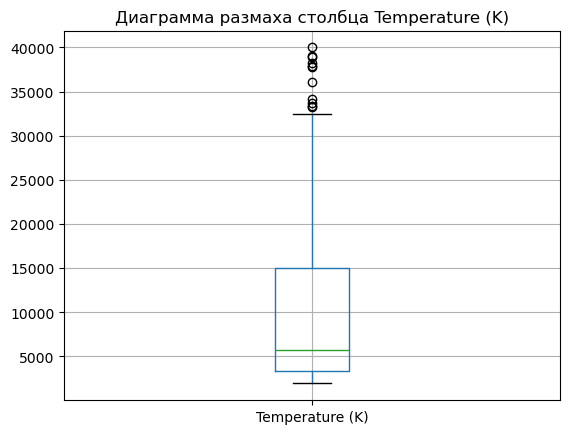

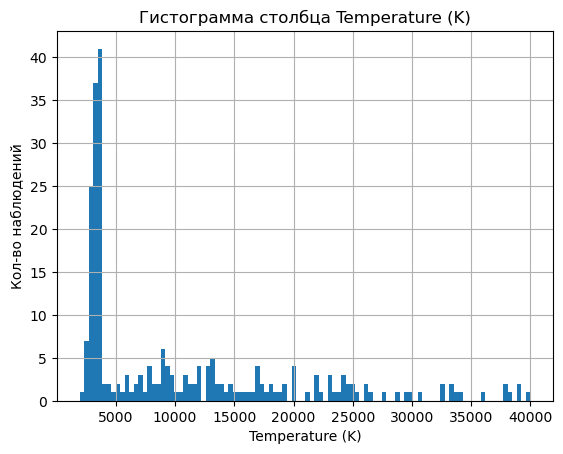

-------------------------------------------------


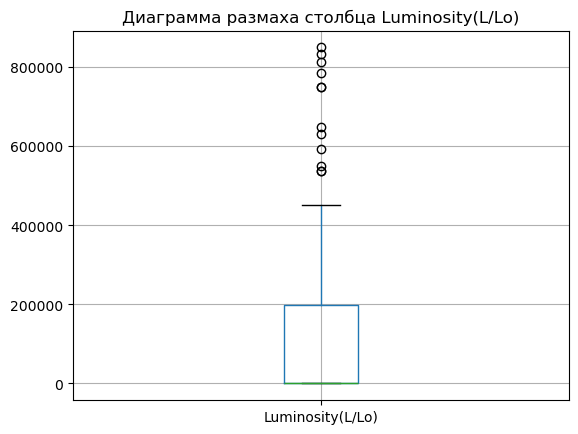

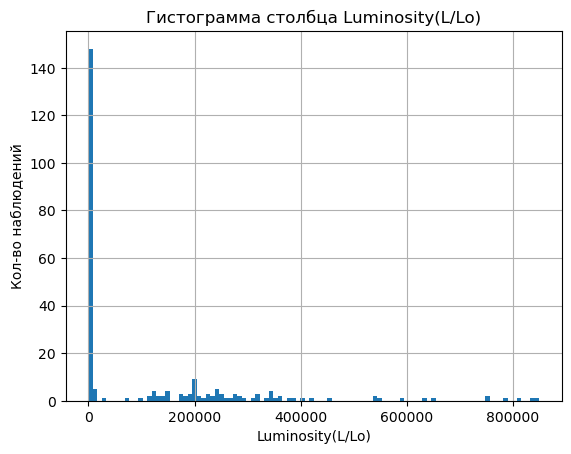

-------------------------------------------------


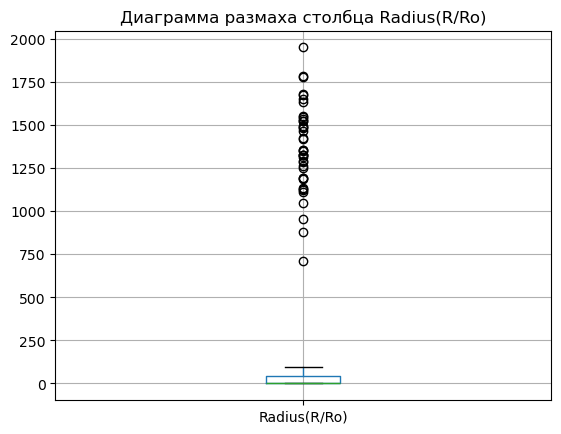

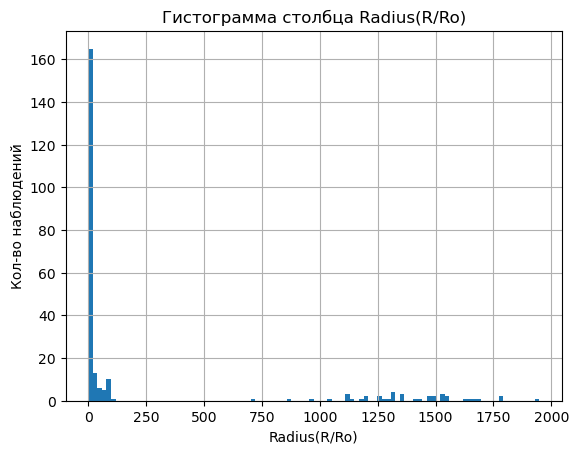

-------------------------------------------------


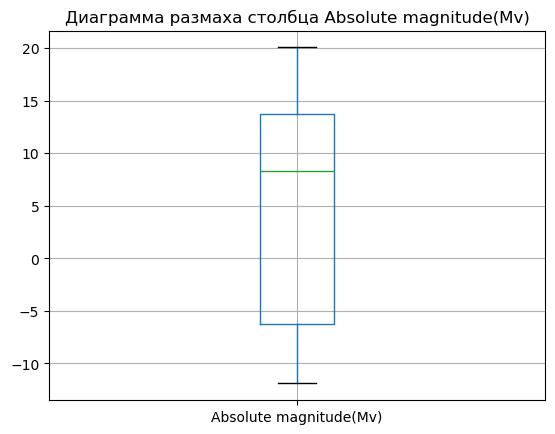

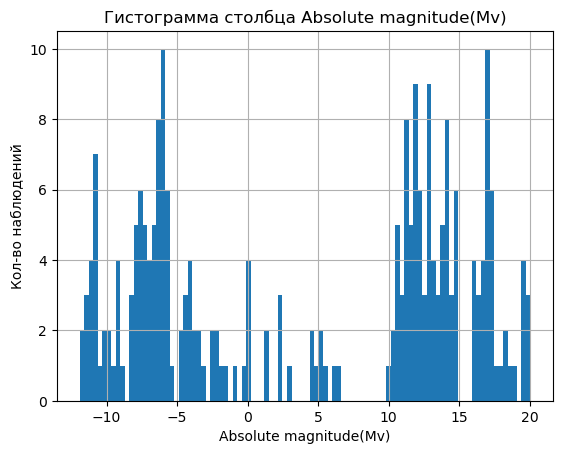

-------------------------------------------------


In [28]:
# Определим количественные столбцы
numeric_columns = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Построим диаграммы размаха и гистограммы для количественных столбцов
data_spread(numeric_columns, df)


In [29]:
# Преобразование столбцов 'Star type' и 'Star color' в категориальные типы данных
df['Star type'] = df['Star type'].astype('category')
df['Star color'] = df['Star color'].astype('category')
categorical_columns = df.select_dtypes(include='category').columns.tolist()
# Проанализируем каждый столбец
for column in categorical_columns:
    analyze_column(df[column])


Количество значений NaN: 0
Количество уникальных значений: 6
Количество каждого уникального значения:
0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64
Количество значений NaN: 0
Количество уникальных значений: 9
Количество каждого уникального значения:
red                   112
blue                   56
blue-white             41
white                  12
white-yellow           12
yellow                  3
orange                  2
orange-red              1
pale yellow-orange      1
Name: Star color, dtype: int64


In [30]:
# Обработка редких категорий для столбца 'Star color'
value_counts = df['Star color'].value_counts()
rare_categories = value_counts[value_counts < 10].index

# Заменим редкие категории на 'Other'
df['Star color'] = df['Star color'].apply(lambda x: 'Other' if x in rare_categories else x)

# Проверим результат
print(df['Star color'].value_counts())

red             112
blue             56
blue-white       41
white            12
white-yellow     12
Other             7
Name: Star color, dtype: int64


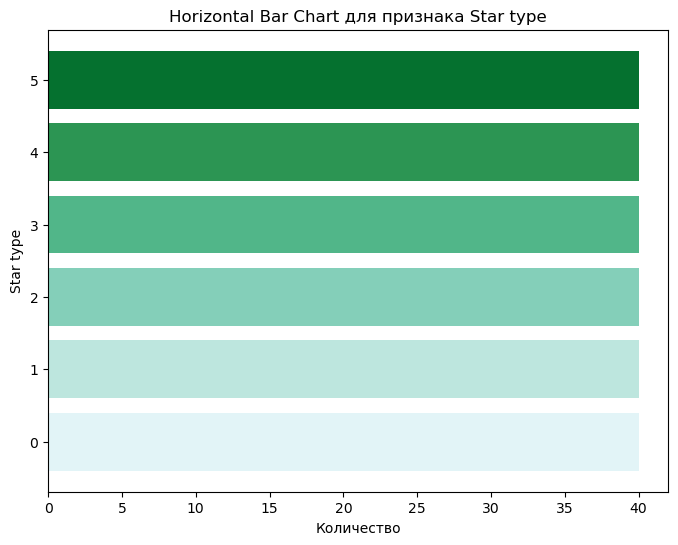

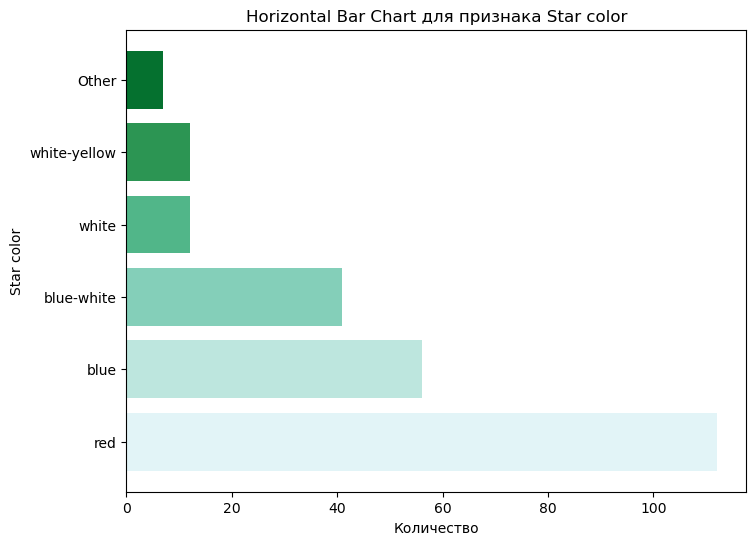

In [31]:
# Построим столбчатые диаграммы для категориальных данных
plot_barh_charts(df)


In [32]:
# Создание новых признаков
df['Log Luminosity'] = np.log1p(df['Luminosity(L/Lo)'])
df['Luminosity per Radius'] = df['Luminosity(L/Lo)'] / df['Radius(R/Ro)']
df = df.drop(columns=['Unnamed: 0'])

interval columns not set, guessing: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Log Luminosity', 'Luminosity per Radius']


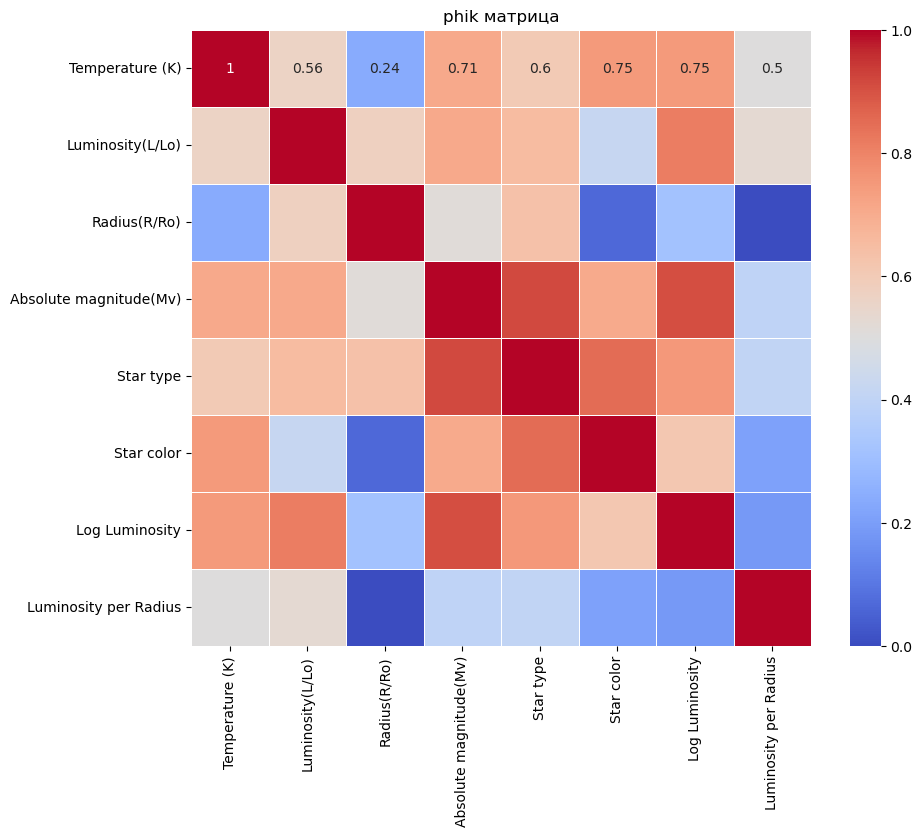

In [33]:
# Построим матрицу корреляций и тепловую карту

plt.figure(figsize=(10, 8))
sns.heatmap(df.phik_matrix(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('phik матрица')
plt.show()

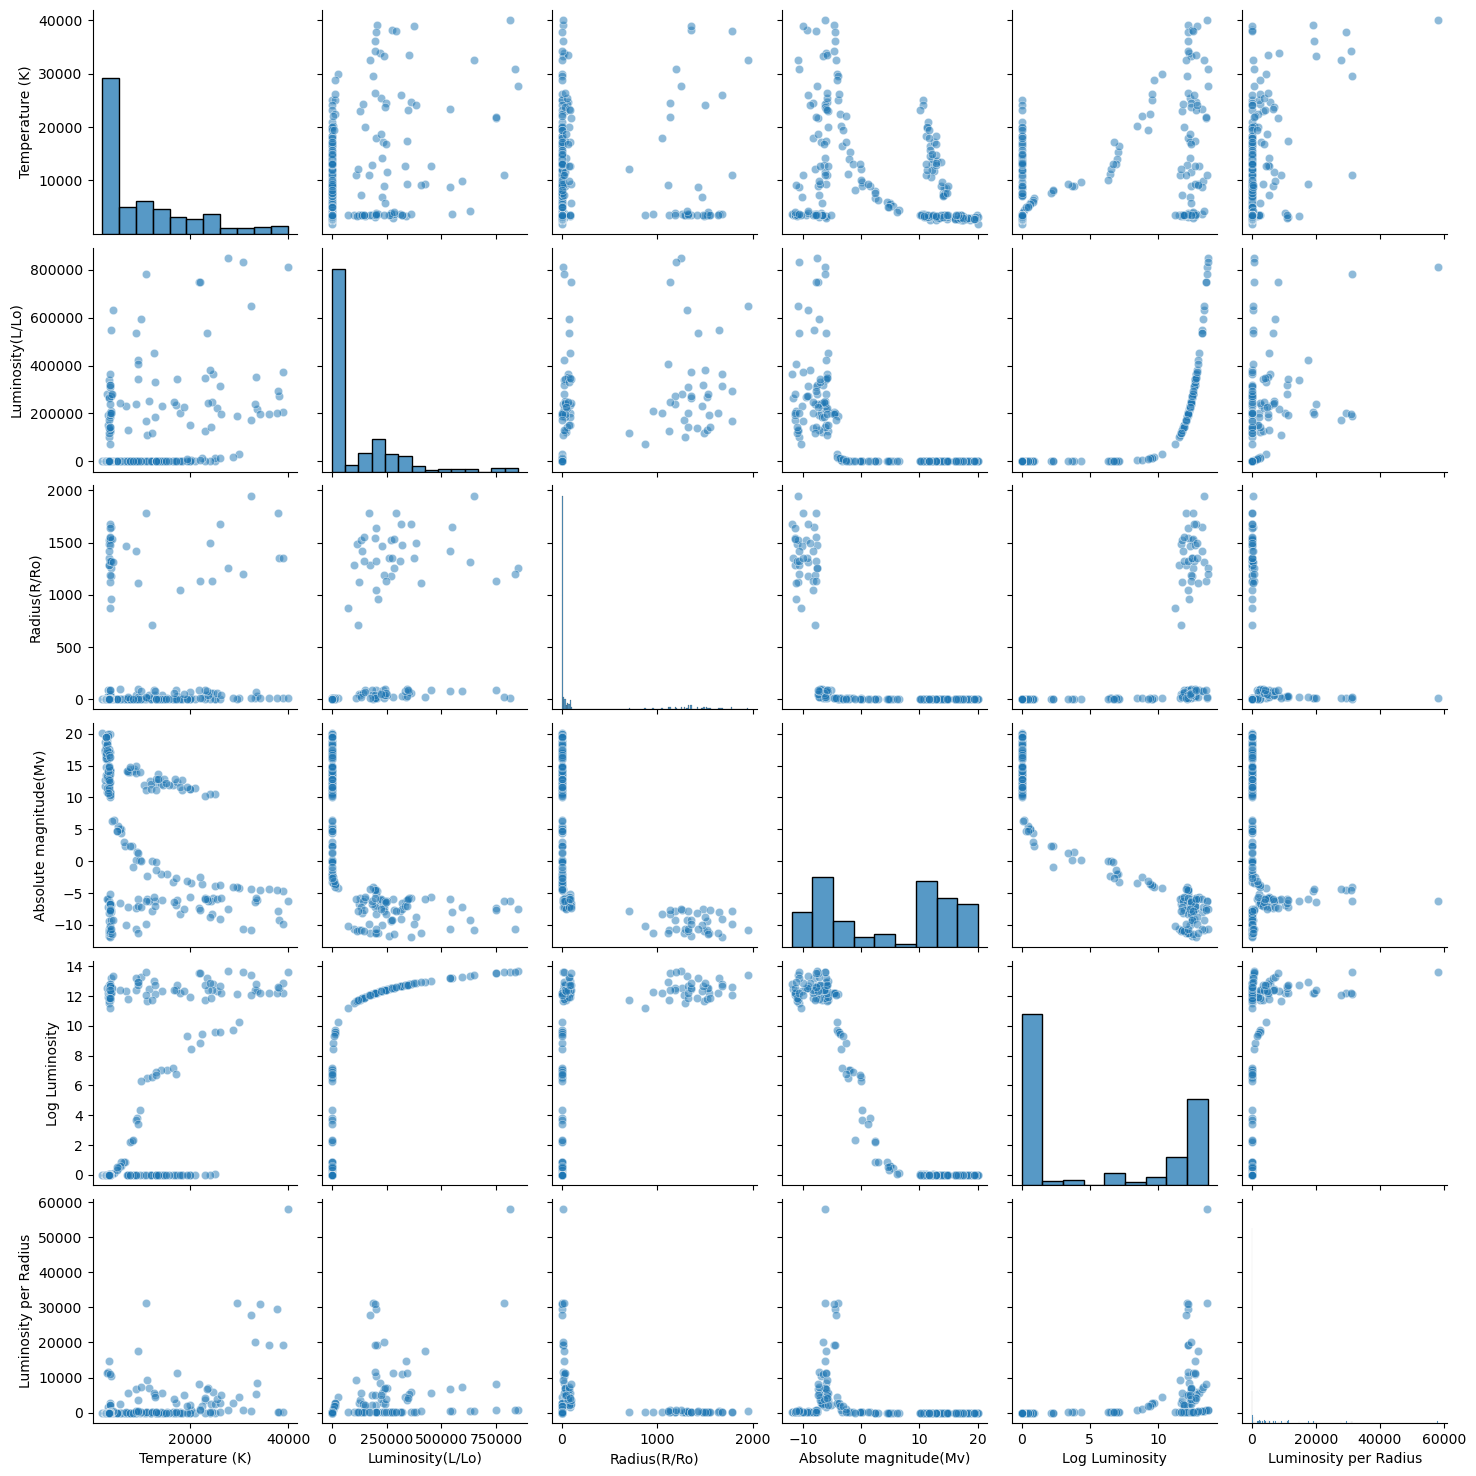

In [34]:
# Построим диаграммы рассеивания для всех пар числовых столбцов
plot_scatter_plots(df)


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Temperature (K)         240 non-null    int64   
 1   Luminosity(L/Lo)        240 non-null    float64 
 2   Radius(R/Ro)            240 non-null    float64 
 3   Absolute magnitude(Mv)  240 non-null    float64 
 4   Star type               240 non-null    category
 5   Star color              240 non-null    object  
 6   Log Luminosity          240 non-null    float64 
 7   Luminosity per Radius   240 non-null    float64 
dtypes: category(1), float64(5), int64(1), object(1)
memory usage: 13.7+ KB


## Подготовка данных к построению модели

In [36]:
# Определим признаки и целевую переменную
X = df.drop(['Temperature (K)'], axis=1)
y = df['Temperature (K)']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [37]:

# Создание трансформеров
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='error')  # 'drop' чтобы избежать мультиколлинеарности
target_column = 'Temperature (K)'
numeric_columns = [col for col in numeric_columns if col != target_column]
# Создание трансформеров для числовых и категориальных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропущенных значений медианой
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Добавление полиномиальных признаков до куба
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Заполнение пропущенных значений
    ('onehot', OneHotEncoder(drop='first'))  # 'drop' чтобы избежать мультиколлинеарности
])

# Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Применяем преобразования к данным
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Построение базовой нейронной сети

In [38]:

# Преобразуем данные в тензоры
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

# Создадим DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [39]:
# Определим класс для нейронной сети
class BaselineNN(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, act_fn1, act_fn2, act_fn3):
        super(BaselineNN, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = act_fn1
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = act_fn2
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = act_fn3
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

# Определим класс для ранней остановки
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Определим количество входных признаков
input_dim = X_train.shape[1]
n_hidden_neurons_1 = 64
n_hidden_neurons_2 = 32
n_out_neurons = 1

# Определим активационные функции
act_fn1 = nn.ReLU()
act_fn2 = nn.ReLU()
act_fn3 = nn.Identity()  # Для регрессии лучше всего использовать Identity для выходного слоя

# Создадим модель
Baseline_model = BaselineNN(input_dim, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, act_fn1, act_fn2, act_fn3)

# Определим функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(Baseline_model.parameters(), lr=1e-3)

# Обучение модели с ранней остановкой
early_stopping = EarlyStopping(patience=100, min_delta=1.0)

num_epochs = 100000
for epoch in range(num_epochs):
    Baseline_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = Baseline_model(inputs).flatten()
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if epoch % 1 == 0:
        Baseline_model.eval()
        predicted_temp = []
        with torch.no_grad():
            test_loss = 0.0
            for inputs, targets in test_loader:
                predictions = Baseline_model(inputs).flatten()
                test_loss += torch.sqrt(criterion(predictions, targets)).item()
                predicted_temp.append(predictions)
        
        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = root_mean_squared_error(y_test, predicted_temp)
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse_bas = RMSE
            best_predicted_temp = predicted_temp
        print(f"Эпоха [{epoch}/{num_epochs}], Средняя ошибка: {running_loss/len(train_loader):.4f}, RMSE на тесте: {RMSE:.4f}")

        if early_stopping.early_stop:
            print('Ранняя остановка!')
            print(f'Лучший RMSE на тесте: {best_rmse_bas:.4f}')
            break


Эпоха [0/100000], Средняя ошибка: 13503.6967, RMSE на тесте: 17652.5273
Эпоха [1/100000], Средняя ошибка: 13243.7341, RMSE на тесте: 17652.0547
Эпоха [2/100000], Средняя ошибка: 13731.0601, RMSE на тесте: 17651.4668
Эпоха [3/100000], Средняя ошибка: 13476.3597, RMSE на тесте: 17650.6328
Эпоха [4/100000], Средняя ошибка: 13701.2818, RMSE на тесте: 17649.4395
Эпоха [5/100000], Средняя ошибка: 13612.8443, RMSE на тесте: 17647.8145
Эпоха [6/100000], Средняя ошибка: 13681.5540, RMSE на тесте: 17645.5801
Эпоха [7/100000], Средняя ошибка: 13636.0345, RMSE на тесте: 17642.4902
Эпоха [8/100000], Средняя ошибка: 13607.1334, RMSE на тесте: 17638.2578
Эпоха [9/100000], Средняя ошибка: 13556.0049, RMSE на тесте: 17632.8027
Эпоха [10/100000], Средняя ошибка: 13701.1459, RMSE на тесте: 17625.8203
Эпоха [11/100000], Средняя ошибка: 13521.0159, RMSE на тесте: 17616.3320
Эпоха [12/100000], Средняя ошибка: 13604.1985, RMSE на тесте: 17604.3301
Эпоха [13/100000], Средняя ошибка: 13536.2543, RMSE на тесте:

## Улучшение нейронной сети

In [40]:
# Функция для установки начального значения для воспроизводимости
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Установим начальное значение
set_seed(123)

# Определим улучшенную модель с фиксированными активационными функциями
class ImprovedNN(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Identity()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

# Определим класс для ранней остановки
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Определим класс для ранней остановки в Optuna
class OptunaEarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_value = None
        self.early_stop = False

    def __call__(self, value):
        if self.best_value is None:
            self.best_value = value
        elif value > self.best_value - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_value = value
            self.counter = 0

# Определим функцию для оптимизации
def objective(trial):
    # Определение гиперпараметров
    n_hidden_neurons_1 = trial.suggest_int('n_hidden_neurons_1', 32, 64)
    n_hidden_neurons_2 = trial.suggest_int('n_hidden_neurons_2', 16, 32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Создадим модель
    model = ImprovedNN(input_dim, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)

    # Определим функцию потерь и оптимизатор
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Создадим DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Обучение модели с ранней остановкой по эпохам
    early_stopping = EarlyStopping(patience=100, min_delta=1.0)
    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).flatten()
            loss = torch.sqrt(criterion(outputs, targets))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if epoch % 1 == 0:
            model.eval()
            predicted_temp = []
            with torch.no_grad():
                test_loss = 0.0
                for inputs, targets in test_loader:
                    predictions = model(inputs).flatten()
                    test_loss += torch.sqrt(criterion(predictions, targets)).item()
                    predicted_temp.append(predictions)

            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            RMSE = root_mean_squared_error(y_test, predicted_temp)
            early_stopping(RMSE)
            if early_stopping.early_stop:
                break

    return early_stopping.best_score

# Определим и запустим исследование с использованием tqdm для прогресса
optuna_early_stopping = OptunaEarlyStopping(patience=10, min_delta=0.01)
study = optuna.create_study(direction='minimize')

for trial in tqdm.tqdm(range(100)):
    study.optimize(objective, n_trials=1)
    optuna_early_stopping(study.best_value)
    if optuna_early_stopping.early_stop:
        print(f'Optuna триал остановлен досрочно на триале {trial+1}')
        break

# Выводим лучшие параметры и метрику
print(f'Лучшие параметры: {study.best_params}')
print(f'Лучший RMSE: {study.best_value:.4f}')


[I 2024-09-02 13:08:03,119] A new study created in memory with name: no-name-cec2aaaa-f230-4852-8c44-2fd7582fd2df
 23%|██▎       | 23/100 [05:13<17:30, 13.64s/it]

Optuna триал остановлен досрочно на триале 24
Лучшие параметры: {'n_hidden_neurons_1': 42, 'n_hidden_neurons_2': 20, 'dropout_rate': 0.028700202454121082, 'batch_size': 16, 'lr': 0.09118243955176888}
Лучший RMSE: 4218.6255


In [41]:
import copy

# Обучение модели с лучшими параметрами
best_params = study.best_params

# Создадим модель с лучшими параметрами
best_model = ImprovedNN(
    input_dim, 
    best_params['n_hidden_neurons_1'], 
    best_params['n_hidden_neurons_2'], 
    n_out_neurons, 
    best_params['dropout_rate']
)

# Определим функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

# Создадим DataLoader
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Определим раннюю остановку
early_stopping = EarlyStopping(patience=1000, min_delta=1.0)

# Переменные для отслеживания лучшей модели
best_rmse = float('inf')
best_epoch = 0
best_model_weights = None

num_epochs = 100000
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs).flatten()
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 1 == 0:
        best_model.eval()
        predicted_temp = []
        with torch.no_grad():
            test_loss = 0.0
            for inputs, targets in test_loader:
                predictions = best_model(inputs).flatten()
                test_loss += torch.sqrt(criterion(predictions, targets)).item()
                predicted_temp.append(predictions)

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = root_mean_squared_error(y_test, predicted_temp)

        # Сохраняем копию весов модели
        if RMSE < best_rmse:
            best_rmse = RMSE
            best_epoch = epoch
            best_model_weights = copy.deepcopy(best_model.state_dict())

        early_stopping(RMSE)
        print(f"Эпоха [{epoch}/{num_epochs}], Средняя ошибка: {running_loss/len(train_loader):.4f}, RMSE на тесте: {RMSE:.4f}")

        if early_stopping.early_stop:
            print('Ранняя остановка!')
            print(f'Лучший RMSE на тесте: {best_rmse:.4f} на эпохе {best_epoch}')
            break



Эпоха [0/100000], Средняя ошибка: 12096.0851, RMSE на тесте: 14276.9541
Эпоха [1/100000], Средняя ошибка: 10249.9347, RMSE на тесте: 11600.7744
Эпоха [2/100000], Средняя ошибка: 7537.0886, RMSE на тесте: 10653.2549
Эпоха [3/100000], Средняя ошибка: 6585.9614, RMSE на тесте: 8659.5654
Эпоха [4/100000], Средняя ошибка: 6377.7833, RMSE на тесте: 10362.3506
Эпоха [5/100000], Средняя ошибка: 6363.0249, RMSE на тесте: 9495.0322
Эпоха [6/100000], Средняя ошибка: 5831.0054, RMSE на тесте: 8379.4229
Эпоха [7/100000], Средняя ошибка: 5441.3061, RMSE на тесте: 10238.5479
Эпоха [8/100000], Средняя ошибка: 5752.9161, RMSE на тесте: 8050.6836
Эпоха [9/100000], Средняя ошибка: 5256.6875, RMSE на тесте: 8311.6865
Эпоха [10/100000], Средняя ошибка: 4894.1821, RMSE на тесте: 8992.2578
Эпоха [11/100000], Средняя ошибка: 4913.3670, RMSE на тесте: 7527.9873
Эпоха [12/100000], Средняя ошибка: 4886.8650, RMSE на тесте: 7030.8257
Эпоха [13/100000], Средняя ошибка: 4620.3078, RMSE на тесте: 8034.9189
Эпоха [14

In [42]:
# Восстановим модель с лучшими весами
if best_model_weights is not None:
    best_model.load_state_dict(best_model_weights)
    print("Модель восстановлена с лучшей эпохи.")

# Предсказания для тестовой выборки с базовой моделью
Baseline_model.eval()
with torch.no_grad():
    y_pred_baseline = Baseline_model(X_test).numpy().flatten()

# Используем модель для предсказаний с лучшей эпохи
best_model.eval()
with torch.no_grad():
    y_pred_optimized = best_model(X_test).numpy().flatten()

# Вычисление RMSE для базовой и оптимизированной моделей
rmse_baseline = root_mean_squared_error(y_test, y_pred_baseline)
rmse_optimized = root_mean_squared_error(y_test, y_pred_optimized)

print(f"Baseline RMSE: {rmse_baseline}")
print(f"Optimized RMSE: {rmse_optimized}")


Модель восстановлена с лучшей эпохи.
Baseline RMSE: 5432.92724609375
Optimized RMSE: 3273.4111328125


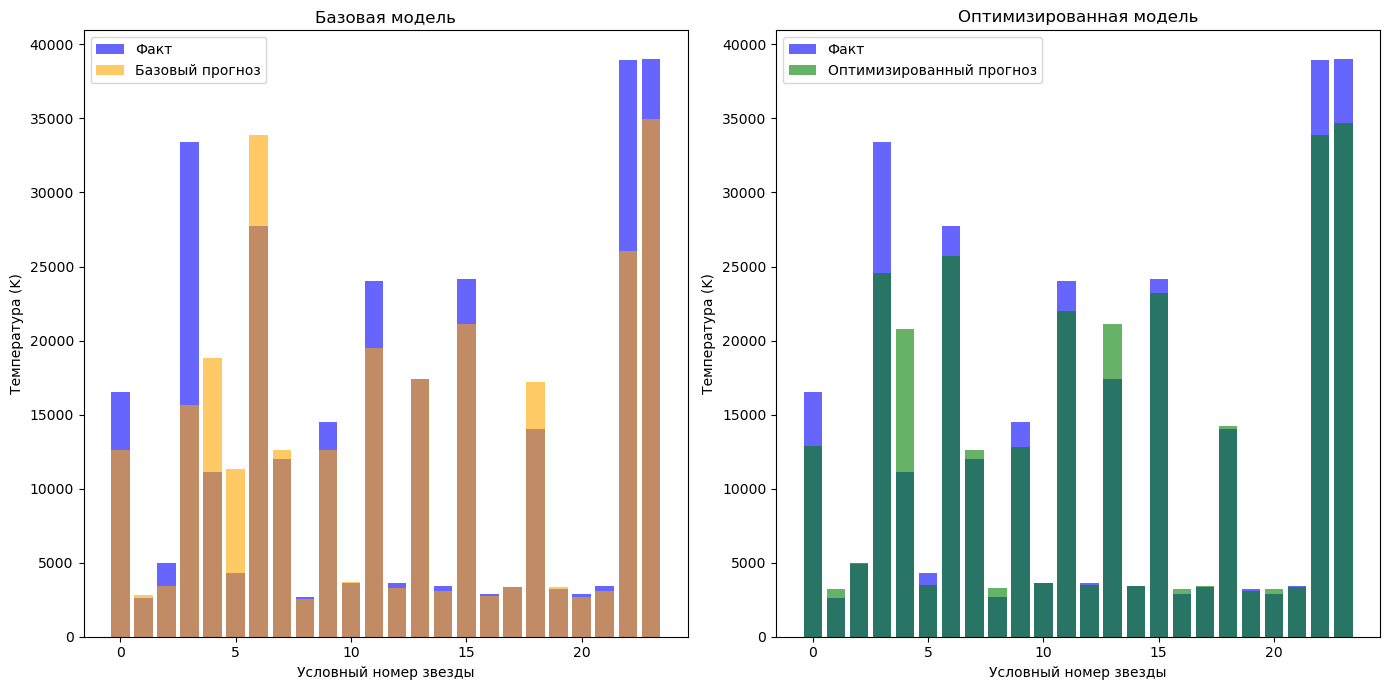

In [43]:
# Построение графиков
plt.figure(figsize=(14, 7))

# График для базовой модели
plt.subplot(1, 2, 1)
indices = range(len(y_test))  # Индексы для оси X
plt.bar(indices, y_test, label='Факт', color='blue', alpha=0.6)
plt.bar(indices, y_pred_baseline, label='Базовый прогноз', color='orange', alpha=0.6)
plt.xlabel('Условный номер звезды')
plt.ylabel('Температура (K)')
plt.title('Базовая модель')
plt.legend()

# График для оптимизированной модели
plt.subplot(1, 2, 2)
plt.bar(indices, y_test, label='Факт', color='blue', alpha=0.6)
plt.bar(indices, y_pred_optimized, label='Оптимизированный прогноз', color='green', alpha=0.6)
plt.xlabel('Условный номер звезды')
plt.ylabel('Температура (K)')
plt.title('Оптимизированная модель')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
# Сравнительная таблица
comparison_df = pd.DataFrame({
    'Модель': ['Базовая', 'Оптимизированная'],
    'RMSE': [rmse_baseline, rmse_optimized]
})

display(comparison_df)


,Модель,RMSE
0,Базовая,5432.927246
1,Оптимизированная,3273.411133


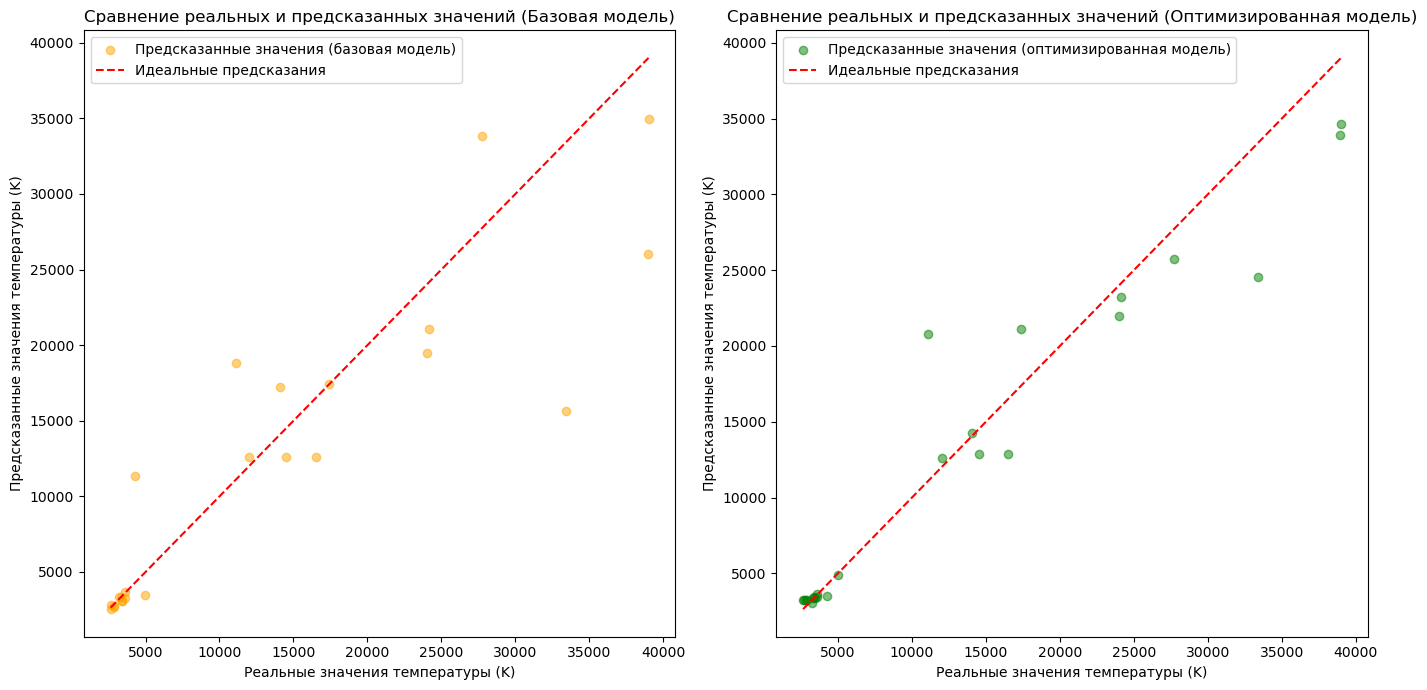

In [45]:
def plot_regression_results(y_true, y_pred_baseline, y_pred_optimized):
    plt.figure(figsize=(14, 7))

    # Диаграмма рассеяния для базовой модели
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred_baseline, color='orange', alpha=0.5, label='Предсказанные значения (базовая модель)')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Идеальные предсказания')
    plt.xlabel('Реальные значения температуры (K)')
    plt.ylabel('Предсказанные значения температуры (K)')
    plt.title('Сравнение реальных и предсказанных значений (Базовая модель)')
    plt.legend()

    # Диаграмма рассеяния для оптимизированной модели
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred_optimized, color='green', alpha=0.5, label='Предсказанные значения (оптимизированная модель)')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Идеальные предсказания')
    plt.xlabel('Реальные значения температуры (K)')
    plt.ylabel('Предсказанные значения температуры (K)')
    plt.title('Сравнение реальных и предсказанных значений (Оптимизированная модель)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Пример использования функции
plot_regression_results(y_test, y_pred_baseline, y_pred_optimized)


## Выводы